In [1]:
pip install folktables xgboost tqdm torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import folktables
from folktables import ACSDataSource, ACSEmployment, ACSIncome
from xgboost import XGBClassifier

import sklearn as sk
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error,confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import uniform,randint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=['TX'], download=True)

features, label, group = ACSIncome.df_to_pandas(acs_data)
features

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,21.0,3.0,16.0,5.0,3500.0,48.0,17.0,10.0,2.0,2.0
1,20.0,1.0,16.0,5.0,4720.0,39.0,17.0,50.0,2.0,1.0
2,31.0,1.0,17.0,5.0,4110.0,48.0,17.0,30.0,1.0,1.0
3,39.0,1.0,21.0,1.0,4255.0,18.0,16.0,40.0,1.0,1.0
4,18.0,1.0,16.0,5.0,4055.0,48.0,17.0,20.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...
135919,19.0,1.0,19.0,5.0,9620.0,48.0,2.0,40.0,1.0,1.0
135920,24.0,1.0,19.0,5.0,4760.0,48.0,10.0,40.0,1.0,1.0
135921,40.0,1.0,15.0,5.0,6260.0,48.0,12.0,40.0,1.0,1.0
135922,43.0,1.0,1.0,2.0,6330.0,17.0,0.0,48.0,1.0,1.0



Meilleurs paramètres = XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.23824102323332486, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

 0.1718411704117882


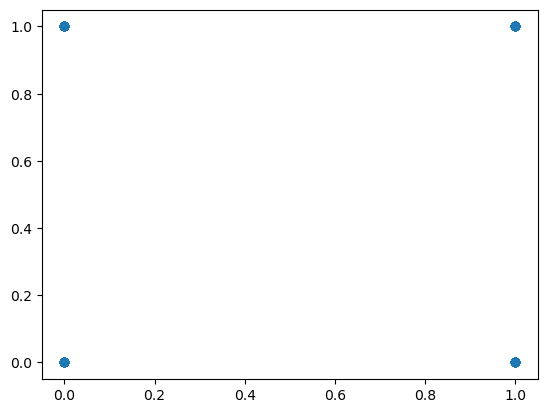

In [4]:
#On isole la colonne PINCP (label) pour essayer de la prédire sur l'ensemble de test
X_train, X_test, Y_train, Y_test = train_test_split(features,label,train_size=0.7)


#parameters = {"learning_rate":uniform(0.01,1)}
parameters = {"max_depth":randint(2,7),"learning_rate":uniform(0.01,1)}
model = XGBClassifier()

gbt = RandomizedSearchCV(model,param_distributions=parameters,n_iter=10,scoring="neg_mean_squared_error")

gbt.fit(X_train,Y_train)
print("\nMeilleurs paramètres =",gbt.best_estimator_)
Y_train_pred = gbt.predict(X_train)

plt.scatter(Y_train,Y_train_pred,alpha=0.01)

print("\n",mean_absolute_error(Y_train,Y_train_pred))

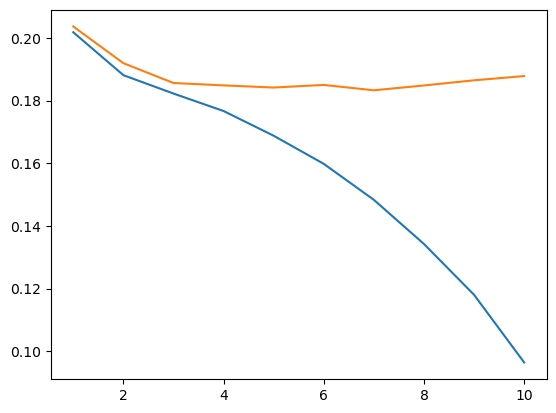

In [5]:
train_errors = []
test_errors = []

X_train, X_test, Y_train, Y_test = train_test_split(features,label,train_size=0.7)

n=10
for k in range(1,n+1):
    clf_XGB = XGBClassifier(max_depth=k, n_estimators = 100, random_state=8)
    clf_XGB.fit(X_train, Y_train.astype(int))
    y_train_pred_XGB = clf_XGB.predict(X_train)
    y_test_pred_XGB = clf_XGB.predict(X_test)
    #plt.scatter(Y_train,y_train_pred_XGB,alpha=0.01)
    #plt.scatter(Y_test,y_test_pred_XGB,alpha=0.01)
    train_errors.append([k,mean_absolute_error(Y_train,y_train_pred_XGB)])
    test_errors.append([k,mean_absolute_error(Y_test,y_test_pred_XGB)])
    #print("\n",mean_absolute_error(Y_train,y_train_pred_XGB))
    #print(mean_absolute_error(Y_test,y_test_pred_XGB))

plt.plot([train_errors[k][0] for k in range(n)],[train_errors[k][1] for k in range(n)])
plt.plot([test_errors[k][0] for k in range(n)],[test_errors[k][1] for k in range(n)])

### Détermination n_estimations : erreur de test environ constante = 0.19 entre 50 et 400 estimateurs
### Détermination max_depth : erreur de test minimale pour max_depth = 6 (remonte un peu à partir de 8/10)



 0.14348474975301115
0.18649762126636912


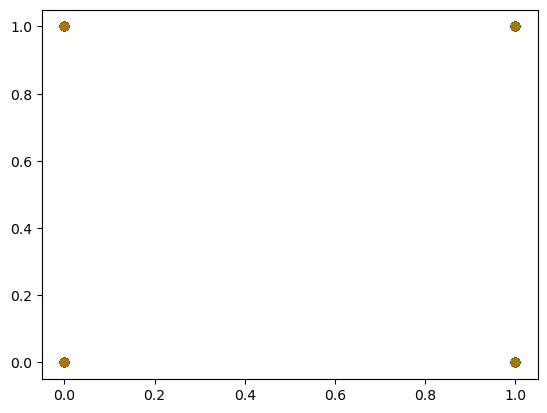

In [6]:
train_errors = []
test_errors = []

X_train, X_test, Y_train, Y_test = train_test_split(features,label,train_size=0.7)



clf_XGB = XGBClassifier(max_depth=6, n_estimators = 200, random_state=8)
clf_XGB.fit(X_train, Y_train.astype(int))
y_train_pred_XGB = clf_XGB.predict(X_train)
y_test_pred_XGB = clf_XGB.predict(X_test)
plt.scatter(Y_train,y_train_pred_XGB,alpha=0.01)
plt.scatter(Y_test,y_test_pred_XGB,alpha=0.01)

print("\n",mean_absolute_error(Y_train,y_train_pred_XGB))
print(mean_absolute_error(Y_test,y_test_pred_XGB))

In [7]:
from math import sqrt

def phi(cm):
    n = len(str(np.max(cm)))
    cm_00 = cm[0,0]/10**n
    cm_01 = cm[0,1]/10**n
    cm_10 = cm[1,0]/10**n
    cm_11 = cm[1,1]/10**n
    return (cm_00*cm_11-cm_01*cm_10)/(sqrt((cm_00+cm_01)*(cm_01+cm_11)*(cm_11+cm_10)*(cm_10+cm_00)))

In [8]:
cm_train = confusion_matrix(Y_train,y_train_pred_XGB)
print(phi(cm_train))
cm_train

0.6886499972849425


array([[54098,  6405],
       [ 7247, 27396]])

In [9]:
cm_test = confusion_matrix(Y_test,y_test_pred_XGB)
print(phi(cm_test))
cm_test

0.5954176900529171


array([[22312,  3524],
       [ 4081, 10861]])

In [10]:
#usefull for preprocessing data, before using gems2
from tqdm import tqdm
import torch
import torch.nn as nn

#1) define the NN classifier model
class MyNN(nn.Module):
    def __init__(self,p):

            super().__init__()  #p is the dimension of the inputs => to change for each NN
            self.fc1 = nn.Linear(p, p)
            self.relu1 = nn.ReLU()
            self.dout1 = nn.Dropout(0.1)
            self.fc2 = nn.Linear(p, p)
            self.relu2 = nn.ReLU()
            self.dout2 = nn.Dropout(0.05)
            self.fc3 = nn.Linear(p, p)
            self.relu3 = nn.ReLU()
            self.dout3 = nn.Dropout(0.05)
            self.fc4 = nn.Linear(p, 1)
            self.out_act = nn.Sigmoid()

    def forward(self, input_):
            a1 = self.fc1(input_)
            h1 = self.relu1(a1)
            dout1 = self.dout1(h1)
            a2 = self.fc2(dout1)
            h2 = self.relu2(a2)
            dout2 = self.dout2(h2)
            a3 = self.fc3(dout2)
            h3 = self.relu3(a3)
            dout3 = self.dout3(h3)
            a4 = self.fc4(dout3)
            y = self.out_act(a4)
            return y

    def predict(self,input_):
            pred = self.forward(input_)

            return torch.tensor(1.*(pred>0.5))

    def predict_proba(self,input_):
            pred = self.forward(input_)

            return torch.tensor(pred)



class SimpleNNclassifier():
    """
    Instanciate and train a simple NN classifier using a single command line. Although Pytorch is
    used in this class, all inputs and outputs are numpy arrays.

    * This class is initiated and trained with the inputs:
      -> A numpy array X of input observations
      -> A numpy array y of output observations with labels

    * As in sklearn, the predict method will used to predict y
    on new observations have the same structure as X.
    """

    def __init__(self,p):
        self.p = p
        print('SimpleNNclassifier created')

    #2) init method of SimpleNNclassifier
    def fit(self,X_train,y_train,epochs_nb=1000,batch_size=300,optimizer='SGD'):
        """
        parameters:
         - epochs_nb: epochs number
         - batch_size: batch size
         - optimizer: optimizer in ['SGD','ADAM']
        """
        #2.1) instantiate and parametrize the model
        X_trainS=sk.preprocessing.scale(X_train)

        n=X_trainS.shape[0]
        p=X_trainS.shape[1]

        #Initialize the model

        self.model = MyNN(self.p)
        #Define loss criterion
        #criterion = nn.BCELoss()
        criterion = nn.MSELoss()
        #Define the optimizer
        if optimizer=='SGD':
            optimizer = torch.optim.SGD(self.model.parameters(),lr=0.0001)
        else:
            optimizer = torch.optim.Adam(self.model.parameters())

        #2.3) train the model

        losses_train = []
        for i in tqdm(range(epochs_nb)):
            for beg_i in range(0, n-batch_size-1, batch_size):
                X = torch.from_numpy(X_trainS[beg_i:beg_i+batch_size,:].astype(np.float32))
                y = torch.from_numpy(y_train.reshape(-1,1)[beg_i:beg_i+batch_size,:].astype(np.float32))

                #Precit the output for Given input
                y_pred = self.model.forward(X)
                #Compute Cross entropy loss
                loss = criterion(y_pred,y.view(1, -1))
                #Add loss to the list
                losses_train.append(loss.item())

                ###losses_women_train.append(loss_women.item())

                ###losses_men_train.append(loss_men.item())
                #Compute gradients
                loss.backward()
                #Adjust weights
                optimizer.step()
        plt.plot(losses_train)
        plt.show()

    #3) Prediction
    def predict(self,X_test):
        X_testS=sk.preprocessing.scale(X_test)
        X_test_torch = torch.from_numpy(X_testS.astype(np.float32))
        y_test_pred_torch=self.model.predict(X_test_torch)
        return y_test_pred_torch.numpy()

    def predict_proba(self,X_test):
        X_testS=sk.preprocessing.scale(X_test)
        X_test_torch = torch.from_numpy(X_testS.astype(np.float32))
        y_test_pred_torch=self.model.predict_proba(X_test_torch)
        return 1.-y_test_pred_torch.numpy()  #probability to be equal to 0 actually

In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

###### Your favorite learning algorithm here #####
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train.values.ravel())

yhat = model.predict(X_test)

white_tpr = np.mean(yhat[(np.array(y_test['PINCP']) == 1) & (np.array(group_test['RAC1P']) == 1)])
black_tpr = np.mean(yhat[(np.array(y_test['PINCP']) == 1) & (np.array(group_test['RAC1P']) == 2)])

# Equality of opportunity violation: 0.0871
white_tpr - black_tpr

0.13271913084417797

Mesure du biais avec la variable "SEX"

- Avec la variable "SEX" dans RL, XGB, NN

SimpleNNclassifier created


  0%|                                                                          | 0/100 [00:00<?, ?it/s]/home/luana/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/luana/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 146])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/luana/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 0])) that is different to the input size (torch.Siz

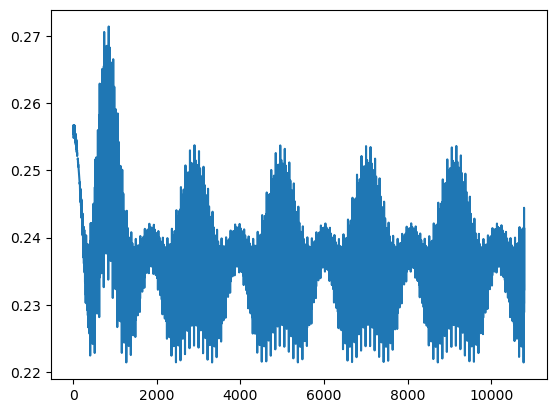

In [12]:
model_NN = SimpleNNclassifier(10)
model_NN.fit(X_train.values,Y_train.values.ravel(),epochs_nb=100,batch_size=1000,optimizer="SGD")

In [13]:
from bias_measure_fcts import Cpt_DI,Cpt_EoO,Cpt_Suf

In [14]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)


print("PREDICTIONS SUR ENSEMBLE DE TEST")

### Régression logistique
print("\n   Régression logistique :")

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, Y_train.values.ravel())

yhat = model.predict(X_test)


print("       - Disparate Impact =",Cpt_DI(2-X_test["SEX"].values,yhat))
print("       - Equality of Odds =",Cpt_EoO(2-X_test["SEX"].values,yhat,Y_test["PINCP"].values))
print("       - Sufficiency =",Cpt_Suf(2-X_test["SEX"].values,yhat,Y_test["PINCP"].values))


### XGBoost
print("\n   XGBoost")

model_xgb = make_pipeline(StandardScaler(),XGBClassifier())
model_xgb.fit(X_train,Y_train.values.ravel())

yhat_xgb = model_xgb.predict(X_test)


print("       - Disparate Impact =",Cpt_DI(2-X_test["SEX"].values,yhat_xgb))
print("       - Equality of Odds =",Cpt_EoO(2-X_test["SEX"].values,yhat_xgb,Y_test["PINCP"].values))
print("       - Sufficiency =",Cpt_Suf(2-X_test["SEX"].values,yhat_xgb,Y_test["PINCP"].values))

### Réseau de Neurones
print("\n   Réseau de neurones")


yhat_nn = model_NN.predict(X_test)


print("       - Disparate Impact =",Cpt_DI(2-X_test["SEX"].values,np.transpose(yhat_nn)[0]))
print("       - Equality of Odds =",Cpt_EoO(2-X_test["SEX"].values,np.transpose(yhat_nn)[0],Y_test["PINCP"].values))
print("       - Sufficiency =",Cpt_Suf(2-X_test["SEX"].values,np.transpose(yhat_nn)[0],Y_test["PINCP"].values))


print("\nVALEURS REELLES")

print("\n       ",np.mean(np.array(label[np.array(features["SEX"]) == 2]["PINCP"]))/np.mean(np.array(label[np.array(features["SEX"]) == 1]["PINCP"])))



PREDICTIONS SUR ENSEMBLE DE TEST

   Régression logistique :
       - Disparate Impact = (0.4713391643703083, [0.4529226701072653, 0.48975565863335135])
       - Equality of Odds = (0.6672685988889003, [0.6428616715798813, 0.6916755261979194])
       - Sufficiency = (0.9006010071781709, [0.8733367652683267, 0.9278652490880152])

   XGBoost
       - Disparate Impact = (0.5697785461948496, [0.5497282283996501, 0.5898288639900491])
       - Equality of Odds = (0.8326442615050209, [0.8096405555844882, 0.8556479674255536])
       - Sufficiency = (0.9296482766774844, [0.906310498902003, 0.9529860544529658])

   Réseau de neurones
       - Disparate Impact = (nan, [nan, nan])
       - Equality of Odds = (nan, [nan, nan])
       - Sufficiency = (nan, [nan, nan])

VALEURS REELLES

        0.6459079095982122


/tmp/ipykernel_310791/2309348904.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))
/home/luana/Bureau/finances/bias_measure_fcts.py:104: RuntimeWarning: divide by zero encountered in scalar divide
  grad_phi_E_T = [E[3]/(E[1]*E[2]) , -(E[0]*E[3])/(E[1]**2*E[2]) , -(E[0]*E[3])/(E[1]*E[2]**2) , E[0]/(E[1]*E[2])]
/home/luana/Bureau/finances/bias_measure_fcts.py:104: RuntimeWarning: invalid value encountered in scalar divide
  grad_phi_E_T = [E[3]/(E[1]*E[2]) , -(E[0]*E[3])/(E[1]**2*E[2]) , -(E[0]*E[3])/(E[1]*E[2]**2) , E[0]/(E[1]*E[2])]
/home/luana/Bureau/finances/bias_measure_fcts.py:111: RuntimeWarning: invalid value encountered in scalar divide
  Center = (E[0]*E[3])/(E[1]*E[2])


- Sans utiliser la variable "SEX" dans RL, XGB, NN

SimpleNNclassifier created


  0%|                                                                          | 0/100 [00:00<?, ?it/s]/home/luana/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


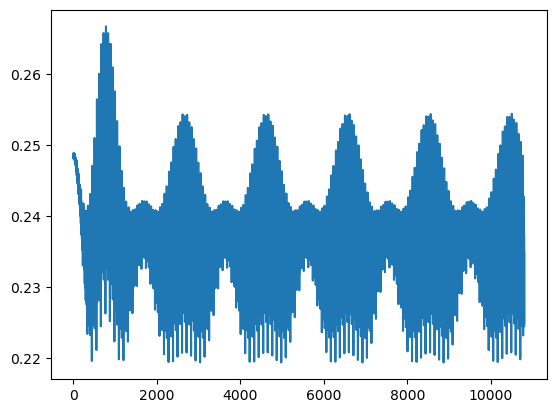

In [15]:
model_NN = SimpleNNclassifier(9)
model_NN.fit(X_train.drop(columns="SEX").values,y_train.values,epochs_nb=100,batch_size=1000,optimizer="SGD")

In [16]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


print("PREDICTIONS SUR ENSEMBLE DE TEST")

### Régression logistique
print("\n   Régression logistique :")

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train.drop(columns="SEX"), Y_train.values.ravel())

yhat = model.predict(X_test.drop(columns="SEX"))


print("       - Disparate Impact =",Cpt_DI(2-X_test["SEX"].values,yhat))
print("       - Equality of Odds =",Cpt_EoO(2-X_test["SEX"].values,yhat,Y_test["PINCP"].values))
print("       - Sufficiency =",Cpt_Suf(2-X_test["SEX"].values,yhat,Y_test["PINCP"].values))


### XGBoost
print("\n   XGBoost")

model_xgb = make_pipeline(StandardScaler(),XGBClassifier())
model_xgb.fit(X_train.drop(columns="SEX"),Y_train.values.ravel())

yhat_xgb = model_xgb.predict(X_test.drop(columns="SEX"))


print("       - Disparate Impact =",Cpt_DI(2-X_test["SEX"].values,yhat_xgb))
print("       - Equality of Odds =",Cpt_EoO(2-X_test["SEX"].values,yhat_xgb,Y_test["PINCP"].values))
print("       - Sufficiency =",Cpt_Suf(2-X_test["SEX"].values,yhat_xgb,Y_test["PINCP"].values))

### Réseau de Neurones
print("\n   Réseau de neurones")


yhat_nn = model_NN.predict(X_test.drop(columns="SEX"))


print("       - Disparate Impact =",Cpt_DI(2-X_test["SEX"].values,np.transpose(yhat_nn)[0]))
print("       - Equality of Odds =",Cpt_EoO(2-X_test["SEX"].values,np.transpose(yhat_nn)[0],Y_test["PINCP"].values))
print("       - Sufficiency =",Cpt_Suf(2-X_test["SEX"].values,np.transpose(yhat_nn)[0],Y_test["PINCP"].values))


print("\nVALEURS REELLES")

print("\n       ",np.mean(np.array(label[np.array(features["SEX"]) == 2]["PINCP"]))/np.mean(np.array(label[np.array(features["SEX"]) == 1]["PINCP"])))



PREDICTIONS SUR ENSEMBLE DE TEST

   Régression logistique :
       - Disparate Impact = (0.843148236579552, [0.8143393908753014, 0.8719570822838025])
       - Equality of Odds = (1.020025577535305, [0.9893283691767907, 1.0507227858938195])
       - Sufficiency = (0.76961299821222, [0.7472615090501533, 0.7919644873742866])

   XGBoost
       - Disparate Impact = (0.6966029468206897, [0.6732219048399776, 0.7199839888014018])
       - Equality of Odds = (0.9486360616421706, [0.9241190734305874, 0.9731530498537538])
       - Sufficiency = (0.8663224935142888, [0.8442930318178875, 0.8883519552106901])

   Réseau de neurones
       - Disparate Impact = (nan, [nan, nan])
       - Equality of Odds = (nan, [nan, nan])
       - Sufficiency = (nan, [nan, nan])

VALEURS REELLES

        0.6459079095982122


/tmp/ipykernel_310791/2309348904.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))
/home/luana/Bureau/finances/bias_measure_fcts.py:104: RuntimeWarning: divide by zero encountered in scalar divide
  grad_phi_E_T = [E[3]/(E[1]*E[2]) , -(E[0]*E[3])/(E[1]**2*E[2]) , -(E[0]*E[3])/(E[1]*E[2]**2) , E[0]/(E[1]*E[2])]
/home/luana/Bureau/finances/bias_measure_fcts.py:104: RuntimeWarning: invalid value encountered in scalar divide
  grad_phi_E_T = [E[3]/(E[1]*E[2]) , -(E[0]*E[3])/(E[1]**2*E[2]) , -(E[0]*E[3])/(E[1]*E[2]**2) , E[0]/(E[1]*E[2])]
/home/luana/Bureau/finances/bias_measure_fcts.py:111: RuntimeWarning: invalid value encountered in scalar divide
  Center = (E[0]*E[3])/(E[1]*E[2])


Calcul des Disparate Impacts par modèle d'IA (RL,XGB,NN)

In [17]:
list_values = []

for k in range(1000):
    yhat_nn = model_NN.predict(X_test.drop(columns="SEX"))

    H_nn = np.mean(yhat_nn[X_test["SEX"].values == 1])
    F_nn = np.mean(yhat_nn[X_test["SEX"].values == 2])

    list_values.append(Cpt_DI(X_test["SEX"].values,np.transpose(yhat_nn)[0]))


/tmp/ipykernel_310791/2309348904.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))
/home/luana/Bureau/finances/bias_measure_fcts.py:104: RuntimeWarning: divide by zero encountered in scalar divide
  grad_phi_E_T = [E[3]/(E[1]*E[2]) , -(E[0]*E[3])/(E[1]**2*E[2]) , -(E[0]*E[3])/(E[1]*E[2]**2) , E[0]/(E[1]*E[2])]
/home/luana/Bureau/finances/bias_measure_fcts.py:104: RuntimeWarning: invalid value encountered in scalar divide
  grad_phi_E_T = [E[3]/(E[1]*E[2]) , -(E[0]*E[3])/(E[1]**2*E[2]) , -(E[0]*E[3])/(E[1]*E[2]**2) , E[0]/(E[1]*E[2])]
/home/luana/Bureau/finances/bias_measure_fcts.py:111: RuntimeWarning: invalid value encountered in scalar divide
  Center = (E[0]*E[3])/(E[1]*E[2])
/tmp/ipykernel_310791/2309348904.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

ValueError: supplied range of [nan, nan] is not finite

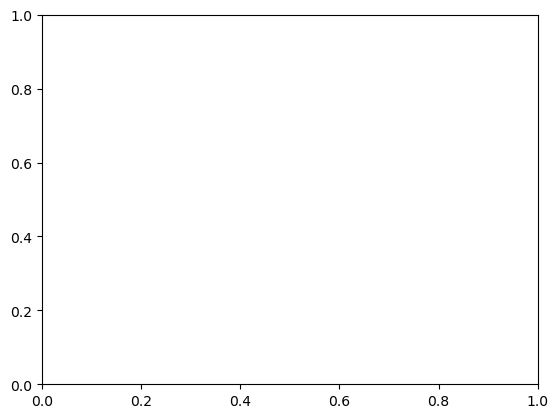

In [18]:
plt.hist([list_values[k][0] for k in range(len(list_values))],range=[0.9*min([list_values[k][0] for k in range(len(list_values))]),1.1*max([list_values[k][0] for k in range(len(list_values))])],bins=200,)